# Project_3: Linear Regressions with Interactions
## Author: Wing Yan Sang
## Date: 11/10/2017

<p><a name="sections"></a></p>


## Sections

- <a href="#skewness">Skewness</a><br>
- <a href="#scaling">Scaling</a><br>
- <a href="#dummification">Dummification</a><br>
- <a href="#splitting">Splitting Data</a><br>
- <a href="#EDA">EDA</a><br>
- <a href="#ridge1">Ridge Regression</a><br> 
- <a href="#results_analy1">Analysis of Results</a><br> 
- <a href="#kaggle1">Kaggle Submission (Ridge)</a><br>
- <a href="#ridge2">Ridge Regression 2</a><br> 
- <a href="#results_analy2">Analysis of Results</a><br> 
- <a href="#lasso">Lasso Regression</a><br>
- <a href="#kaggle2">Kaggle Submission (Lasso)</a><br>
- <a href="#results_analy3">Analysis of Results</a><br> 

In [165]:
#### Loading the packages to be used
from __future__ import print_function 
from pandas.core import datetools
import pandas as pd
import numpy as np
from scipy import stats

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import Ridge, Lasso, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

import statsmodels.api as sm
from  statsmodels.genmod import generalized_linear_model

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import seaborn as sns


In [166]:
# Read in csv files

inter_train = pd.read_csv('Train_Data_Interactions.csv')
inter_test = pd.read_csv('Test_Data_Interactions.csv')

pd.set_option('display.max_columns', 500)

In [167]:
#separate out SalePrice
y = inter_train['SalePrice']
y_log = np.log1p(y)

In [168]:
# Separate out interaction column names
filter_col = ['BsmtQual + BsmtCond', 'ExterQual + ExterCond', 'GarageQual + GarageCond', 'Heating + HeatingQC',
             'HighQualFinishedSF', 'OverallQual * TotalBaths', 'OverallQual * TotalSF', 
              'OverallQual + OverallCond', 'SaleType + SaleCondition', 'TotalBaths * TotalSF', 
                'TotalFinishedSF', 'TotalSF']

#Seperate out numeric column names
num_col = ['HighQualFinishedSF','OverallQual * TotalBaths', 'OverallQual * TotalSF', 'TotalBaths * TotalSF',
            'TotalFinishedSF', 'TotalSF']

#separate out categorical column names
cat_col = ['BsmtQual + BsmtCond', 'ExterQual + ExterCond', 'GarageQual + GarageCond', 'Heating + HeatingQC',
              'OverallQual + OverallCond', 'SaleType + SaleCondition']


In [169]:
#Separate out interaction columns for training and test sets

interact_train = inter_train[filter_col]
interact_test = inter_test[filter_col]

<p><a name="skewness"></a></p>
### Skewness

In [170]:
#Check skewness of numeric interaction columns in training set

for col in num_col:  
    print(interact_train[col].skew())
print (num_col)

#all numeric variables are skewed (>1) except for OverallQual*TotalSF
skewed_col =  ['HighQualFinishedSF', 'OverallQual * TotalSF', 'TotalBaths * TotalSF',
            'TotalFinishedSF', 'TotalSF']

1.77669962724
0.757520454513
2.43960828471
2.5978969391
2.16688958659
1.77802918539
['HighQualFinishedSF', 'OverallQual * TotalBaths', 'OverallQual * TotalSF', 'TotalBaths * TotalSF', 'TotalFinishedSF', 'TotalSF']


In [171]:
#unskew data
df = interact_train.copy()
for col in skewed_col:
    df[col] = np.log(df[col])

#print out skewness after
for col in skewed_col:  
    print(df[col].skew())

#set interact_train equal to df
interact_train = df
del df


-0.349581745014
-0.519875750991
-0.371297480333
-0.0447770630648
-0.344751617274


In [172]:
#Check skewness of numeric interaction columns in test set
for col in num_col:  
    print(interact_test[col].skew())
print (num_col)

1.20801389456
0.888449082964
1.80860669873
1.83397210173
1.47328679178
1.20277845129
['HighQualFinishedSF', 'OverallQual * TotalBaths', 'OverallQual * TotalSF', 'TotalBaths * TotalSF', 'TotalFinishedSF', 'TotalSF']


In [173]:
#unskew data
df = interact_test.copy()
for col in skewed_col:
    df[col] = np.log(df[col])

#print out skewness after
for col in skewed_col:  
    print(df[col].skew())

#set inter_test equal to df
interact_test = df
del df


-0.390648305631
-0.610007620765
-0.332015751407
-0.107079314333
-0.377444036882


<p><a name="scaling"></a></p>
### Scaling

In [174]:
#Scale numeric variables using normal distribution. Scale it according to training and apply to both 
#training and test sets

C =interact_train.copy()
D =interact_test.copy()
scaler = preprocessing.StandardScaler()

scaled_df =pd.DataFrame()
for col in num_col: 
    C[col] = scaler.fit_transform(interact_train[col].values.reshape(-1,1))
    D[col] = scaler.transform(interact_test[col].values.reshape(-1,1))

interact_train = C
interact_test = D

In [175]:
del C, D

In [176]:
# Combine training and test interactions
all_data = pd.concat([interact_train, interact_test])

<p><a name="dummification"></a></p>
### Dummification

In [177]:
#Dummify categorical variables

#First create separate data frame with just categoricals

cat_df = all_data[cat_col]

#Dummify the categoricals
cat_df = pd.get_dummies(cat_df, drop_first=True, dummy_na=False)
cat_df.head()

num_df = all_data[num_col]

all_data = pd.concat([num_df, cat_df], axis = 1)

In [178]:
del cat_df, num_df

<p><a name="splitting"></a></p>
### Create Two Data Frames: Train and Test

In [179]:
#Split all_sub dataset into two: train and test
train_index = len(interact_train)
train = all_data.iloc[:train_index, :]
test = all_data.iloc[train_index:, :]


<p><a name="EDA"></a></p>
### EDA

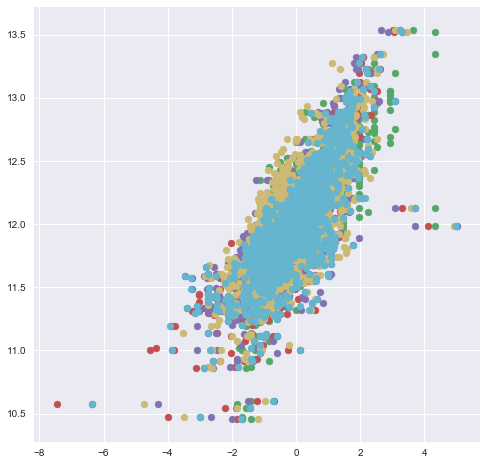

In [180]:
fig, ax = plt.subplots(figsize=(8,8))
for col in num_col: 
    plt.scatter(train[col], y_log)

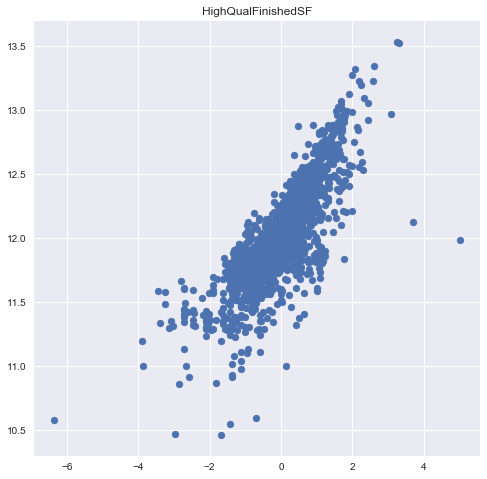

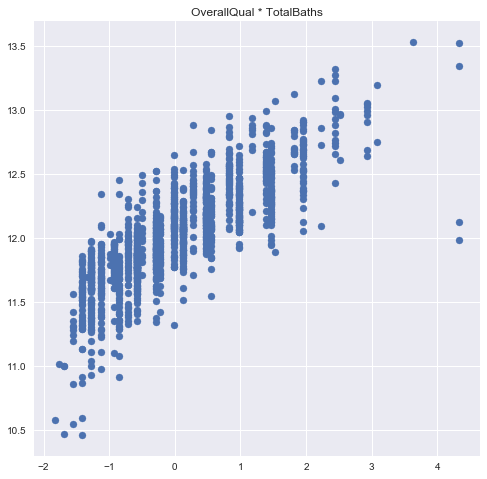

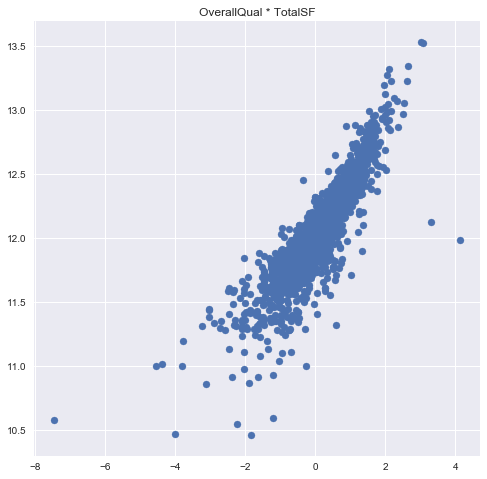

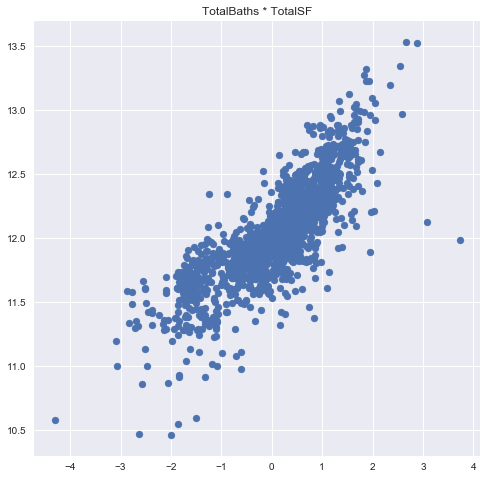

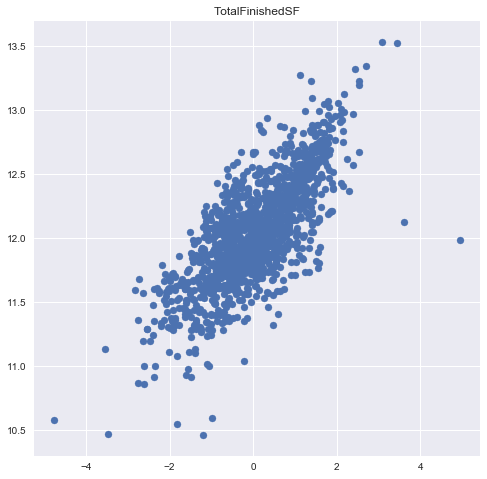

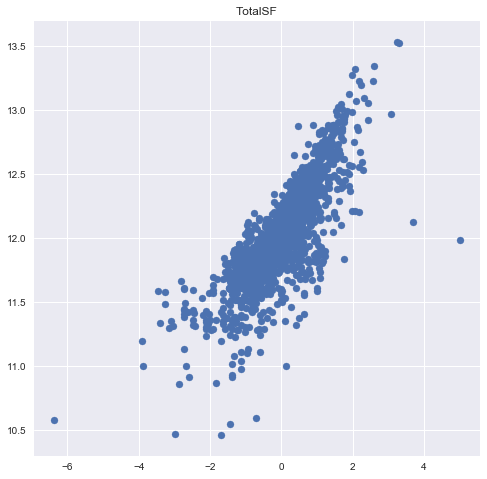

In [181]:
### Scatterplot of numeric variables against log sales price
    
for col in num_col: 
    plt.figure(figsize=(8, 8)) 
    plt.scatter(train[col], y_log) 
    plt.title(col)
    plt.show()

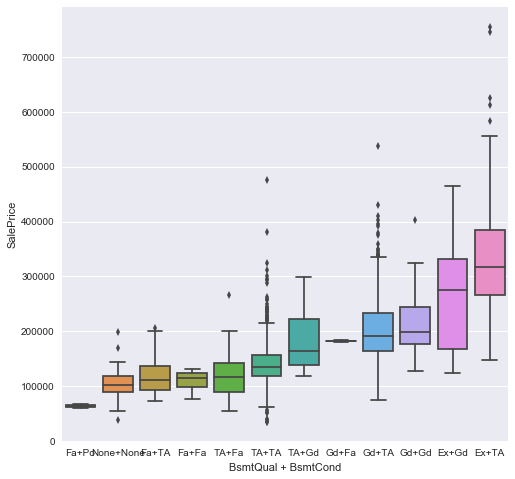

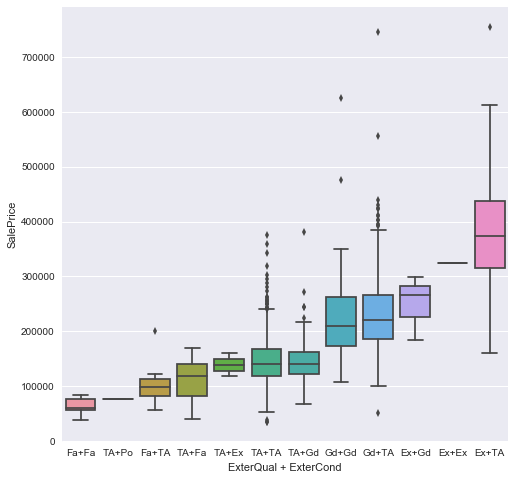

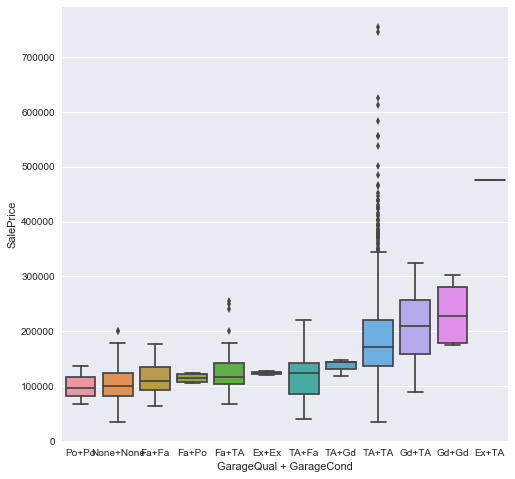

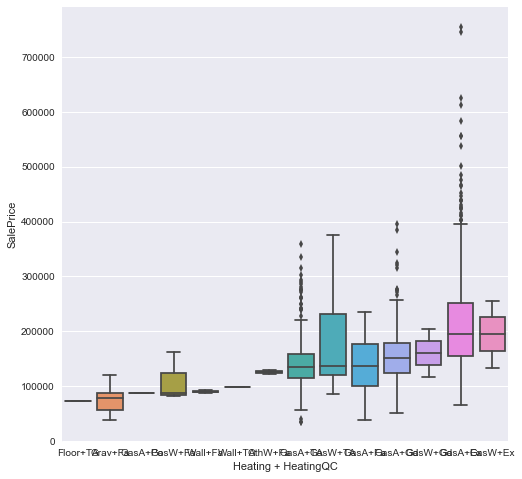

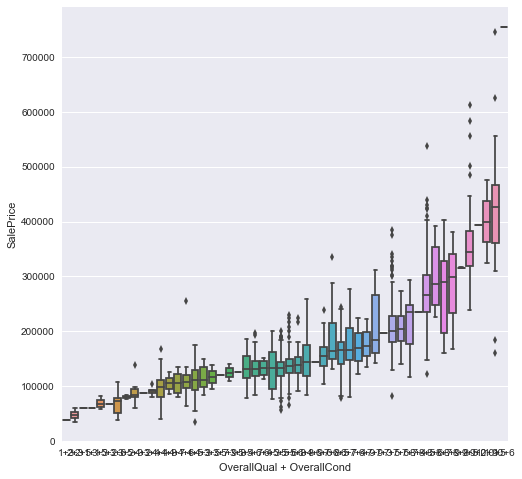

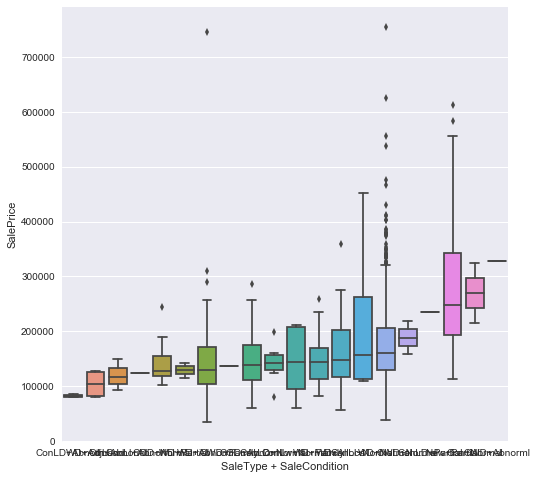

In [182]:
### Boxplots of categorical variables against log sales price
df = pd.concat([interact_train, y], axis = 1)

for col in cat_col:
    n = df.groupby([col])['SalePrice'].apply(np.median)
    n = n.sort_values()
    fig = plt.figure(figsize=(8, 8))
    sns.boxplot(y=df["SalePrice"], x=df[col], order = n.index)

<p><a name="ridge"></a></p>
### Ridge Regression
 - Perform Ridge regression of all variables along with Wing's Regression with 5 Variables 

In [183]:
#Remove outliers (observations 523, 1298)
df = train



In [184]:
#Read in data frame re-index column
train_wing = pd.read_csv('XTrain_Wing.csv')

In [185]:
#Combine with data frame of 5 variables from Wing's original regression. X will be the training set.
X = pd.concat([df, train_wing], axis = 1)

#Remove observations 523 and 1298

X = X.drop(X.index[[523,1298]])
y_log = y_log.drop(y_log.index[[523,1298]])

In [186]:
# Create training and test sets

try:  # train_test_split was moved in 0.18.0
    from sklearn.model_selection import train_test_split
except:  # Following import works through 0.19 but outputs a warning in 0.18
    from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=8)

In [187]:
def rmse_cv(model,x, y):
    rmse= np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [188]:
model_ridge = Ridge()
alphas = np.logspace(0, 2, 100)
cv_ridge = [rmse_cv(Ridge(alpha = alpha), X_train, y_train).mean() 
            for alpha in alphas]

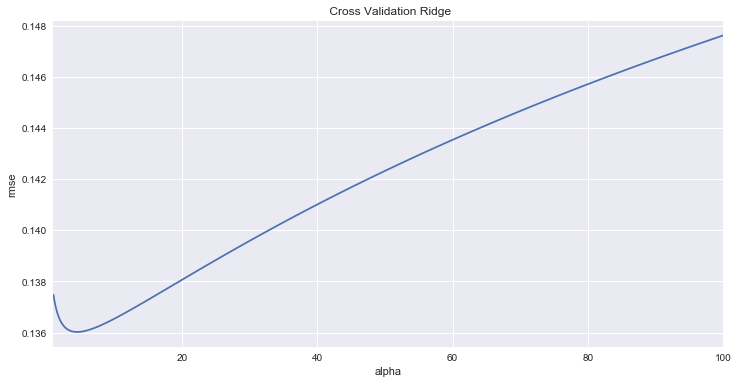

In [189]:
mpl.rcParams['figure.figsize'] = (12.0, 6.0)
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = " Cross Validation Ridge")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [190]:
#Best alpha and rmse
best =cv_ridge[cv_ridge == cv_ridge.min()]
best_alpha = best.index[0]
print(best_alpha)

4.43062145758


In [191]:
#Fitting to entire training subset using best alpha
Ridge_best = Ridge(alpha = best_alpha)
Ridge_best.fit(X_train, y_train)
print("Ridge training R-squared is: %f" %Ridge_best.score(X_train, y_train))

y_predicted_train = Ridge_best.predict(X_train)
mse_train = mean_squared_error(y_train, y_predicted_train)
rms_train = np.sqrt(mean_squared_error(y_train, y_predicted_train))
print("Ridge training RMSE is: %f" %rms_train)

Ridge training R-squared is: 0.908029
Ridge training RMSE is: 0.123603


In [192]:
#Test model against test set. 

y_predicted_test = Ridge_best.predict(X_test)
mse_test = mean_squared_error(y_test, y_predicted_test)
rms_test = np.sqrt(mean_squared_error(y_test, y_predicted_test))
print("Ridge test R-squared is: %f" %Ridge_best.score(X_test, y_test))
print("Ridge test RMSE is: %f" %rms_test)

Ridge test R-squared is: 0.893183
Ridge test RMSE is: 0.118910


In [193]:
#Fitting to entire training set
Ridge_final = Ridge(alpha = best_alpha)
Ridge_final.fit(X, y_log)
print("Ridge R-squared on entire training set is: %f" %Ridge_best.score(X, y_log))

y_predicted = Ridge_final.predict(X)
mse = mean_squared_error(y_log, y_predicted)
rms = np.sqrt(mean_squared_error(y_log, y_predicted))
print("Ridg RMSE is: %f" %rms)

Ridge R-squared on entire training set is: 0.905740
Ridg RMSE is: 0.121406


In [194]:
Ridge_final.get_params()

{'alpha': 4.4306214575838814,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

<p><a name="kaggle1"></a></p>
### Submission to Kaggle (Ridge Regression)
    1. Make Predictions 
    2. Save Results

In [195]:
#add Test columns from Wing's original regression data frame to test
test_wing = pd.read_csv('XTest_Wing.csv') #this csv file contains 1460 rows. no outliers were removed
test_wing = test_wing.drop('const', axis = 1)

In [196]:
#combine the data frames
df = test
X_kaggle = pd.concat([df, test_wing], axis = 1)

In [197]:
#Make predictions
y_test = Ridge_final.predict(X_kaggle)
y_test = np.expm1(y_test)
y_test = pd.DataFrame({'SalePrice': y_test})

In [198]:
test_ID = pd.read_csv('test_ID.csv')

In [199]:
submission_4 = pd.concat([test_ID, y_test], axis = 1)

#write to csv file. Result: 0.13960
submission_4.to_csv("submission_4.csv", index=False)

In [200]:
submission_4.head()

,Id,SalePrice
0,1461,119891.457831
1,1462,157527.763774
2,1463,170051.509199
3,1464,178829.469423
4,1465,207756.242705


<p><a name="results_analy1"></a></p>
### Analysis of Ridge Regression Results

In [201]:
### TO BE FILLED IN

<p><a name="ridge2"></a></p>
### Ridge Regression 2
1. Remove mixed categorical/numeric interactions
2. Add neighborhood full list (25) and overall qual full list (10)

In [202]:
#Create list of column names to add and delete
del_col = ['OverallQual * TotalBaths', 'OverallQual * TotalSF', 'Neigh__2', 'Neigh__3', 'Neigh__4']
add_col = ['Neighborhood', 'OverallQual']

In [203]:
# Drop the columns from the test and training sets
df1 = X.drop(del_col, axis = 1)
df2 = X_kaggle.drop(del_col, axis = 1)

In [204]:
#dummify the new columns
df3 = inter_train[add_col]
df4 = inter_test[add_col]

In [205]:
df3 = df3.drop(df3.index[[523,1298]])

In [206]:

dummy1 = pd.get_dummies(df3, drop_first=True, dummy_na=False)
dummy2 = pd.get_dummies(df4, drop_first=True, dummy_na=False)

In [207]:
qual = pd.get_dummies(dummy1['OverallQual'], prefix='qual', prefix_sep='__')
qual = qual.drop('qual__1', axis=1)
qual2 = pd.get_dummies(dummy2['OverallQual'], prefix='qual', prefix_sep='__')
qual2 = qual2.drop('qual__1', axis=1)

In [208]:
X_copy = pd.concat([df1, df3, dummy1, qual], axis = 1)
X = X_copy

In [211]:
Xtest_copy = pd.concat([df2, df4, dummy2, qual2], axis = 1)
X_kaggle = Xtest_copy

In [216]:
X = X.drop(['Neighborhood'], axis = 1)
X_kaggle = X_kaggle.drop(['Neighborhood'], axis = 1)

- Fit Ridge model to the new X variables

In [219]:
# Create training and test sets

try:  # train_test_split was moved in 0.18.0
    from sklearn.model_selection import train_test_split
except:  # Following import works through 0.19 but outputs a warning in 0.18
    from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=8)

In [220]:
def rmse_cv(model,x, y):
    rmse= np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [295]:
model_ridge = Ridge()
alphas = np.logspace(0, 2, 100)
cv_ridge = [rmse_cv(Ridge(alpha = alpha), X_train, y_train).mean() for alpha in alphas]
alphas

array([   1.        ,    1.04761575,    1.09749877,    1.149757  ,
          1.20450354,    1.26185688,    1.32194115,    1.38488637,
          1.45082878,    1.51991108,    1.59228279,    1.66810054,
          1.7475284 ,    1.83073828,    1.91791026,    2.009233  ,
          2.10490414,    2.20513074,    2.3101297 ,    2.42012826,
          2.53536449,    2.65608778,    2.7825594 ,    2.91505306,
          3.05385551,    3.19926714,    3.35160265,    3.51119173,
          3.67837977,    3.85352859,    4.03701726,    4.22924287,
          4.43062146,    4.64158883,    4.86260158,    5.09413801,
          5.33669923,    5.59081018,    5.85702082,    6.13590727,
          6.42807312,    6.73415066,    7.05480231,    7.39072203,
          7.74263683,    8.11130831,    8.49753436,    8.90215085,
          9.32603347,    9.77009957,   10.23531022,   10.72267222,
         11.23324033,   11.76811952,   12.32846739,   12.91549665,
         13.53047775,   14.17474163,   14.84968262,   15.55676

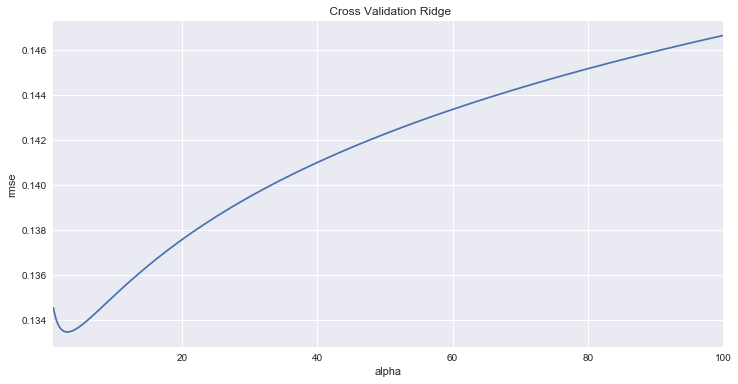

In [222]:
mpl.rcParams['figure.figsize'] = (12.0, 6.0)
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = " Cross Validation Ridge")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [223]:
#Best alpha and rmse
best =cv_ridge[cv_ridge == cv_ridge.min()]
best_alpha = best.index[0]
print(best_alpha)

3.05385550883


In [224]:
#Fitting to entire training subset using best alpha
Ridge_best = Ridge(alpha = best_alpha)
Ridge_best.fit(X_train, y_train)
print("Ridge training R-squared is: %f" %Ridge_best.score(X_train, y_train))

y_predicted_train = Ridge_best.predict(X_train)
mse_train = mean_squared_error(y_train, y_predicted_train)
rms_train = np.sqrt(mean_squared_error(y_train, y_predicted_train))
print("Ridge training RMSE is: %f" %rms_train)

Ridge training R-squared is: 0.915437
Ridge training RMSE is: 0.118520


In [225]:
#Test model against test set. 

y_predicted_test = Ridge_best.predict(X_test)
mse_test = mean_squared_error(y_test, y_predicted_test)
rms_test = np.sqrt(mean_squared_error(y_test, y_predicted_test))
print("Ridge test R-squared is: %f" %Ridge_best.score(X_test, y_test))
print("Ridge test RMSE is: %f" %rms_test)

Ridge test R-squared is: 0.898920
Ridge test RMSE is: 0.115673


In [268]:
#Fitting to entire training set
Ridge_final = Ridge(alpha = best_alpha)
Ridge_final.fit(X, y_log)
print("Ridge R-squared on entire training set is: %f" %Ridge_best.score(X, y_log))

y_predicted = Ridge_final.predict(X)
mse = mean_squared_error(y_log, y_predicted)
rms = np.sqrt(mean_squared_error(y_log, y_predicted))
print("Ridg RMSE is: %f" %rms)

Ridge R-squared on entire training set is: 0.912856
Ridg RMSE is: 0.116694


In [269]:
Ridge_final.get_params()

{'alpha': 3.0538555088334154,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

<p><a name="kaggle3"></a></p>
### Submission to Kaggle (Ridge Regression2)
    1. Make Predictions 
    2. Save Results

In [270]:
#Make predictions
y_test = Ridge_final.predict(X_kaggle)
y_test = np.expm1(y_test)
y_test = pd.DataFrame({'SalePrice': y_test})

In [271]:
test_ID = pd.read_csv('test_ID.csv')

In [290]:
submission_6 = pd.concat([test_ID, y_test], axis = 1)

#write to csv file. Result: 0.13761
submission_6.to_csv("submission_6.csv", index=False)

In [291]:
submission_6.describe()

,Id,SalePrice
count,1459.000000,1459.000000
mean,2190.000000,178402.715460
std,421.321334,74693.787469
min,1461.000000,40060.897206
25%,1825.500000,128491.000889
50%,2190.000000,158737.615356
75%,2554.500000,209984.450552
max,2919.000000,745572.371731


<p><a name="results_analy2"></a></p>
### Analysis of Ridge Regression 2 Results

1. List of Variables by Coefficients
2. Analysis of Residuals

In [292]:
### create diction of features and coefficients
coef_dictRidge = {}
for coef, feat in zip(Ridge_final.coef_,X_kaggle.columns):
    coef_dictRidge[feat] = coef
    


In [293]:
#Sort dictionary by coefficients from highest to lowest. In terms of absolute value, OverallQual+OverallCond
#appear to be very important
from operator import itemgetter
sorted(coef_dictRidge.items(), key=itemgetter(1), reverse = True)

[('Neighborhood_NoRidge', 0.12666486464073909),
 ('OverallQual + OverallCond_5+9', 0.10305474686080655),
 ('Neighborhood_ClearCr', 0.09968028954576974),
 ('Neighborhood_Crawfor', 0.091807765043861234),
 ('SaleType + SaleCondition_New+Partial', 0.089987802449692927),
 ('OverallQual + OverallCond_5+8', 0.088714817335380544),
 ('SaleType + SaleCondition_ConLD+Normal', 0.088531505042499167),
 ('SaleType + SaleCondition_Con+Normal', 0.084429045501999533),
 ('OverallQual + OverallCond_5+7', 0.081626638207132465),
 ('Neighborhood_StoneBr', 0.081205669959185836),
 ('OverallQual + OverallCond_6+7', 0.078887545813435669),
 ('Neighborhood_NridgHt', 0.074418720683467499),
 ('HighQualFinishedSF', 0.070295383091982938),
 ('OverallQual + OverallCond_10+9', 0.069295463250892253),
 ('ExterQual + ExterCond_TA+Ex', 0.067899485328874742),
 ('TotalFinishedSF', 0.067852403996390268),
 ('OverallQual + OverallCond_4+7', 0.066815421613050263),
 ('Neighborhood_Somerst', 0.064735114099550475),
 ('GarageQual + Ga

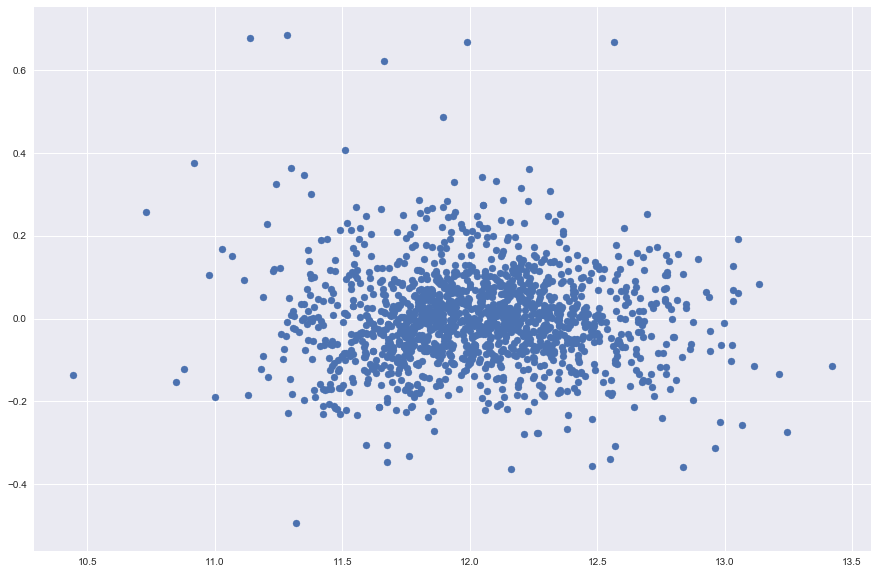

In [281]:
#Residuals vs. Fitted Values. Variance of residuals seem to increase further from the center
residuals = y_predicted - y_log
fig, ax = plt.subplots(figsize=(15,10))
fig = plt.scatter(y_predicted, residuals)

<p><a name="lasso"></a></p>
### Lasso Regression


Remove mixed categorical/numeric interactions
Add neighborhood full list (25) and overall qual full list (10)

In [233]:
# Create training and test sets

try:  # train_test_split was moved in 0.18.0
    from sklearn.model_selection import train_test_split
except:  # Following import works through 0.19 but outputs a warning in 0.18
    from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=8)

In [234]:
# LassoCV
from sklearn.model_selection import GridSearchCV
model = Lasso()
alphas = np.logspace(-3, 2, 100)
grid_param = [{'alpha': alphas}]
grid = GridSearchCV(estimator=model, param_grid=grid_param).fit(X_train, y_train)
print(grid)
print(grid.best_score_)
print(grid.best_estimator_.alpha)

GridSearchCV(cv=None, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': array([  1.00000e-03,   1.12332e-03, ...,   8.90215e+01,   1.00000e+02])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)
0.875767458413
0.001


In [235]:
#Fitting to entire training subset using alpha = .001
Lasso_best = Lasso(alpha = .001)
Lasso_best.fit(X_train, y_train)
print("Lasso training R-squared is: %f" %Lasso_best.score(X_train, y_train))

y_predicted_train = Lasso_best.predict(X_train)
mse_train = mean_squared_error(y_train, y_predicted_train)
rms_train = np.sqrt(mean_squared_error(y_train, y_predicted_train))
print("Lasso training RMSE is: %f" %rms_train)

Lasso training R-squared is: 0.896148
Lasso training RMSE is: 0.131344


In [236]:
#Testing against test set
y_predicted_test = Lasso_best.predict(X_test)
mse_test = mean_squared_error(y_test, y_predicted_test)
rms_test = np.sqrt(mean_squared_error(y_test, y_predicted_test))
print("Lasso test R-squared is: %f" %Lasso_best.score(X_test, y_test))
print("Lasso test RMSE is: %f" %rms_test)

Lasso test R-squared is: 0.899838
Lasso test RMSE is: 0.115146


In [284]:
#Fitting to entire training set. Improves again. 
Lasso_final = Lasso(alpha = .001)
Lasso_final.fit(X, y_log)
print("Lasso R-squared on entire training set is: %f" %Lasso_best.score(X, y_log))

y_predicted = Lasso_final.predict(X)
mse = mean_squared_error(y_log, y_predicted)
rms = np.sqrt(mean_squared_error(y_log, y_predicted))
print("Lasso RMSE is: %f" %rms)

Lasso R-squared on entire training set is: 0.896959
Lasso RMSE is: 0.129335


<p><a name="kaggle2"></a></p>
### Submission to Kaggle (Lasso Regression)
    1. Make Predictions 
    2. Save Results

In [285]:
#Make predictions
y_test = Lasso_final.predict(X_kaggle)
y_test = np.expm1(y_test)
y_test = pd.DataFrame({'SalePrice': y_test})

In [286]:
submission_5 = pd.concat([test_ID, y_test], axis = 1)

#write to csv file. Result: 0.14138
submission_5.to_csv("submission_5.csv", index=False)

<p><a name="results_analy3"></a></p>
### Analysis of Lasso Regression Results

1. List of Variables by Coefficients
2. Analysis of Residuals

In [287]:
### create diction of features and coefficients
coef_dictLasso = {}
for coef, feat in zip(Lasso_final.coef_,X_kaggle.columns):
    coef_dictLasso[feat] = coef
    


In [ ]:
#Sort dictionary by coefficients from highest to lowest
from operator import itemgetter
sorted(coef_dictLasso.items(), key=itemgetter(1), reverse = True)

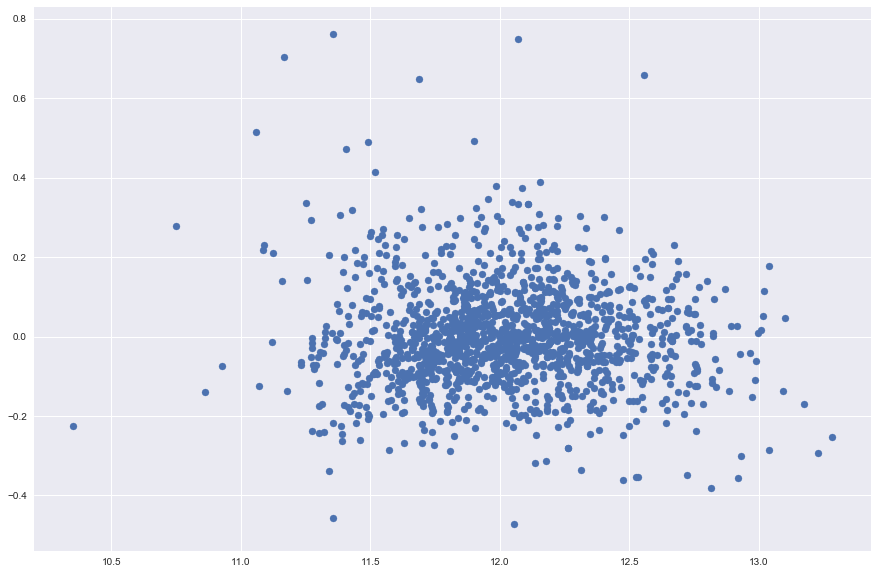

In [289]:
#Residuals vs. Fitted Values. Variance of residuals seem to increase further from the center
residuals = y_predicted - y_log
fig, ax = plt.subplots(figsize=(15,10))
fig = plt.scatter(y_predicted, residuals)